# Transfer learning with cnn

In this notebook we'll try to build a model that is going to work on a bunch of photos taken during a trip in Italy. Few hundred of photos has been taken in different places and show different things.

For the sake of this exercise the dataset has been divided into 4 classes: landscapes, pictures taken in city, depicting a lake or sea and taken inside a building.

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

np.random.seed(10)
tf.random.set_seed(10)

# Loading and preparing data

In [2]:
data_dir  = 'datasets/tmp_photos/'
train_dir = os.path.join(data_dir, 'train_set')
test_dir  = os.path.join(data_dir, 'test_set')

img_shape = (256, 256)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=16,
    image_size=img_shape,
    validation_split=0.35,
    subset="training",
    seed=9)

Found 512 files belonging to 4 classes.
Using 333 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=16,
    image_size=img_shape,
    validation_split=0.35,
    subset="validation",
    seed=9)

Found 512 files belonging to 4 classes.
Using 179 files for validation.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=16,
    image_size=img_shape,
    seed=12)

Found 64 files belonging to 4 classes.


In [6]:
print(f'Number of batches in train_ds: {tf.data.experimental.cardinality(train_ds):2}')
print(f'Number of batches in val_ds:   {tf.data.experimental.cardinality(val_ds):2}')
print(f'Number of batches in test_ds:  {tf.data.experimental.cardinality(test_ds):2}')

Number of batches in train_ds: 21
Number of batches in val_ds:   12
Number of batches in test_ds:   4


Due to small number of pictures some data augmentation will be needed. We'll take care of that later.

In [7]:
class_names = train_ds.class_names
print(class_names)

['city', 'inside', 'landscape', 'water']


Let's have a look at some example photos.

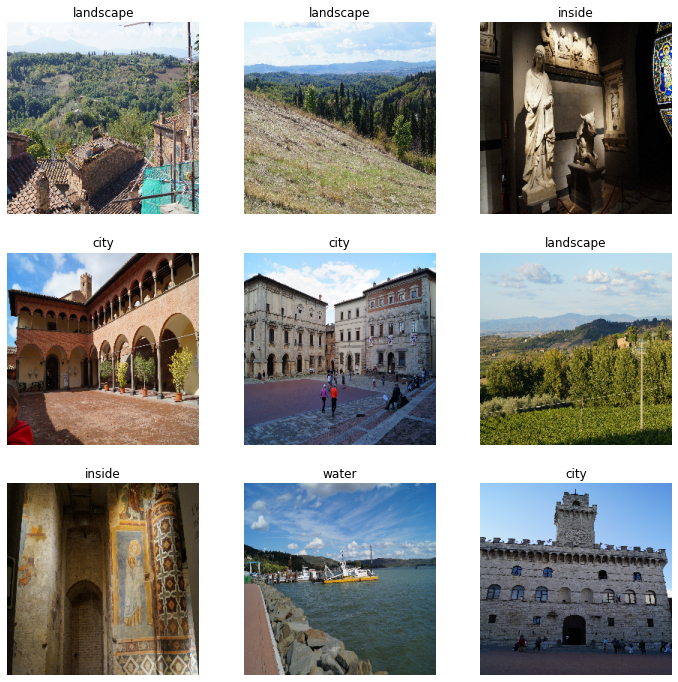

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for batch, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
        plt.axis("off")

And a little care about performance.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().  prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache(). prefetch(buffer_size=AUTOTUNE)

# Choosing and fine-tuning a model

## Data augmentation

As mentioned before we'll implement a little data augmentation block at the base of the model so that it may achieve better performance eventually. Used operations include: horizontal flipping, zooming and a little rotation.

In [10]:
factor = (-0.0, -0.5)

augmenting_block = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal', seed=14),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=factor, width_factor=factor, seed=14),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.07, seed=14)
])

## Selecting a model

We are going to select randomly a model from `keras.applications`, let's say, _MobileNetV3Small_ and see how high accuracy we'll get.

In [11]:
base_model = keras.applications.MobileNetV3Small(include_top=False)
preprocessing_block = keras.applications.mobilenet_v3.preprocess_input

## Feature extraction

Before we jump into fine-tuning, it is recommended to make feature extraction first, i.e. train a model put on top of the base model because of high values of gradients due to random initialized weights in the model on top.

In [12]:
base_model.trainable = False

inputs  = keras.layers.Input(shape=img_shape+(3,))
layer = augmenting_block(inputs)
layer = preprocessing_block(layer)
layer = base_model(layer, training=False)
layer = keras.layers.GlobalAveragePooling2D()(layer)
outputs = keras.layers.Dense(4, activation='softmax')(layer)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])

In [13]:
model.evaluate(val_ds)

12/12 [==============================] - 12s 288ms/step - loss: 2.9719 - acc: 0.1397


[2.97188663482666, 0.13966479897499084]

Accuracy equal to roughly 14% - worse than totally random 25%, but explainable because of few small batches.

In [14]:
feature_extraction_epochs = 8

history = model.fit(train_ds,
                    epochs=feature_extraction_epochs,
                    validation_data=val_ds)

Epoch 1/8
21/21 [==============================] - 25s 771ms/step - loss: 1.8191 - acc: 0.2402 - val_loss: 1.6444 - val_acc: 0.1788
Epoch 2/8
21/21 [==============================] - 8s 377ms/step - loss: 1.2920 - acc: 0.3904 - val_loss: 1.2440 - val_acc: 0.4134
Epoch 3/8
21/21 [==============================] - 7s 340ms/step - loss: 1.1445 - acc: 0.5375 - val_loss: 1.1312 - val_acc: 0.4749
Epoch 4/8
21/21 [==============================] - 7s 355ms/step - loss: 1.0482 - acc: 0.6066 - val_loss: 1.0221 - val_acc: 0.5587
Epoch 5/8
21/21 [==============================] - 7s 344ms/step - loss: 0.9522 - acc: 0.6847 - val_loss: 0.9094 - val_acc: 0.6592
Epoch 6/8
21/21 [==============================] - 7s 342ms/step - loss: 0.8487 - acc: 0.7808 - val_loss: 0.8235 - val_acc: 0.7151
Epoch 7/8
21/21 [==============================] - 7s 342ms/step - loss: 0.7894 - acc: 0.8048 - val_loss: 0.7579 - val_acc: 0.7821
Epoch 8/8
21/21 [==============================] - 8s 369ms/step - loss: 0.7271 - 

## Fine-tuning

Now we dive into fine-tuning and simply try to achieve better results by including into training a few top layers in the base model.

In [15]:
base_model.trainable = True

bottom_ratio = 0.6
n_bottom_layers = int(bottom_ratio * len(base_model.layers))
for layer in base_model.layers[:n_bottom_layers]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00003),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])

In [16]:
fine_tuning_epochs = feature_extraction_epochs  # arbitrary choice
total_epochs = feature_extraction_epochs + fine_tuning_epochs

history2 = model.fit(train_ds,
                     epochs=total_epochs,
                     initial_epoch=feature_extraction_epochs,
                     validation_data=val_ds)

Epoch 9/16
21/21 [==============================] - 15s 558ms/step - loss: 0.5330 - acc: 0.8829 - val_loss: 0.3902 - val_acc: 0.9274
Epoch 10/16
21/21 [==============================] - 12s 582ms/step - loss: 0.3250 - acc: 0.9309 - val_loss: 0.2559 - val_acc: 0.9441
Epoch 11/16
21/21 [==============================] - 12s 575ms/step - loss: 0.2077 - acc: 0.9550 - val_loss: 0.1720 - val_acc: 0.9609
Epoch 12/16
21/21 [==============================] - 10s 490ms/step - loss: 0.1584 - acc: 0.9640 - val_loss: 0.1355 - val_acc: 0.9609
Epoch 13/16
21/21 [==============================] - 10s 493ms/step - loss: 0.1187 - acc: 0.9730 - val_loss: 0.1029 - val_acc: 0.9777
Epoch 14/16
21/21 [==============================] - 10s 492ms/step - loss: 0.0848 - acc: 0.9850 - val_loss: 0.0741 - val_acc: 0.9832
Epoch 15/16
21/21 [==============================] - 10s 492ms/step - loss: 0.0759 - acc: 0.9880 - val_loss: 0.0812 - val_acc: 0.9721
Epoch 16/16
21/21 [==============================] - 10s 483ms/

# Conclusion

In [17]:
train_loss = history.history['loss'] + (history2.history['loss'])
val_loss   = history.history['val_loss'] + (history2.history['val_loss'])
train_acc  = history.history['acc'] + (history2.history['acc'])
val_acc    = history.history['val_acc'] + (history2.history['val_acc'])

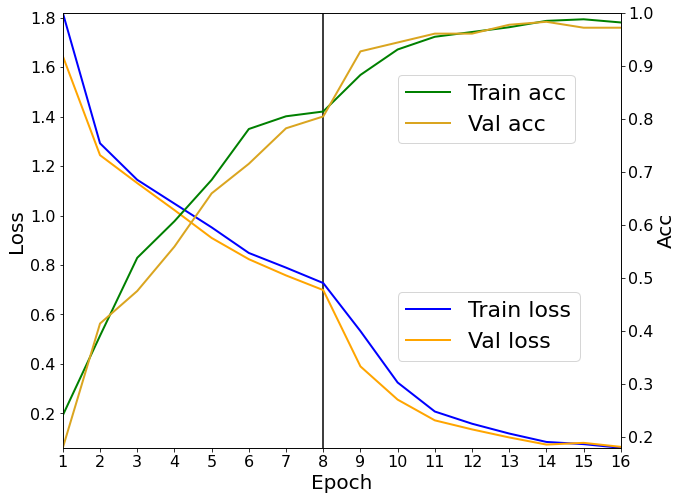

In [18]:
legend_fontsize = 22
ticks_labelsize = 16
ylabel_fontsize = 20
linewidth       = 2

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xticks(np.arange(total_epochs))
ax.set_xticklabels(np.arange(total_epochs)+1, fontsize=ticks_labelsize)
ax.set_xlim(0, total_epochs-1)
ax.set_xlabel('Epoch', fontsize=ylabel_fontsize)

ax.plot(train_loss, color='blue', label='Train loss', linewidth=linewidth)
ax.plot(val_loss, color='orange', label='Val loss', linewidth=linewidth)
ax.vlines(feature_extraction_epochs-1, -1.0, 4.0, color='black')
all_losess = train_loss + val_loss
ax.set_ylim(min(all_losess), max(all_losess))
ax.set_ylabel('Loss', fontsize=ylabel_fontsize)

ax2 = ax.twinx()
ax2.plot(train_acc, color='green', label='Train acc', linewidth=linewidth)
ax2.plot(val_acc, color='goldenrod', label='Val acc', linewidth=linewidth)
all_accs = train_acc + val_acc
ax2.set_ylim(min(all_accs), 1.0)
ax2.set_ylabel('Acc', fontsize=ylabel_fontsize)

ax.tick_params(axis='y', labelsize=ticks_labelsize)
ax2.tick_params(axis='y', labelsize=ticks_labelsize)
ax.legend(loc=(0.6, 0.2), fontsize=legend_fontsize)
ax2.legend(loc=(0.6, 0.7), fontsize=legend_fontsize)

In [19]:
model.evaluate(test_ds)

4/4 [==============================] - 4s 187ms/step - loss: 0.1254 - acc: 0.9688


[0.12543553113937378, 0.96875]

Above 96% accuracy on test set is really good. Despite lower learning rate, switching to fine-tuning accelerated model learning significantly.

Perhaps using one of the two techniques would produce similar results but, all in all, final performance is satisfying.

Let's have a look at misclassified examples.

In [20]:
def plot_misclassified(ds):
    misclassified_images = []
    wrong_labels = []
    true_labels = []

    ds = ds.unbatch().batch(1)

    for image, label in ds:
        pred = model.predict(image).argmax(axis=1)
        if pred != label:
            misclassified_images.append(image.numpy()[0, ...].astype(np.uint8))
            wrong_labels.append(pred)
            true_labels.append(label)

    n_misclassified = len(misclassified_images)

    fontsize = 20
    hor_offset = 40
    ver_offset = 30

    if n_misclassified <= 3:
        plt.figure(figsize=(12, 4))
        nrows = 1
        ncols = n_misclassified
    else:  # assuming not more than 6 misclassified pictures
        plt.figure(figsize=(12, 9))
        nrows = 2
        ncols = (n_misclassified + 1) // 2

    for i in range(n_misclassified):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(misclassified_images[i])
        plt.text(hor_offset, ver_offset,
                 f'True: {class_names[int(true_labels[i])]}',
                 fontsize=fontsize, color='indigo')
        plt.text(hor_offset, 256-ver_offset,
                 f'Pred: {class_names[int(wrong_labels[i])]}',
                 fontsize=fontsize, color='cornsilk')
        plt.axis('off')

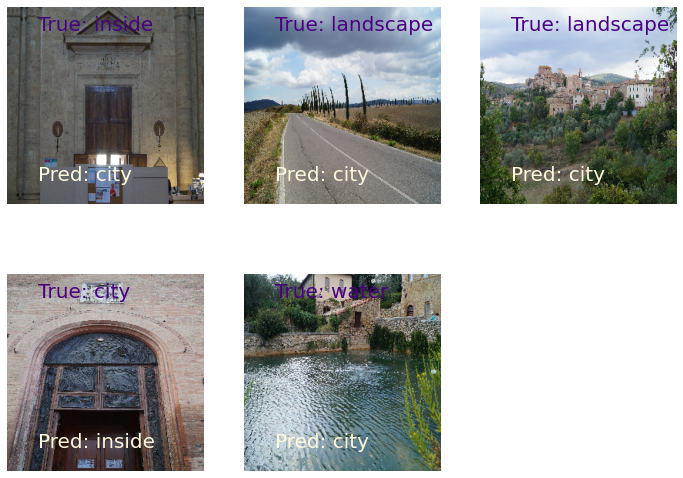

In [21]:
plot_misclassified(val_ds)

In the first column there are 2 photos of doors and distinguishing between entrance and exit apparently requires more specific dataset and model.

The water classified as city seems to have more convincing buildings than the pond. Nonetheless, the photo has been taken in the city so the misclassification is not a big deal.

The two remaining errors look weird, especially the road with a cypress line along. There are no buildings in that picture so the prediction is hard to explain.

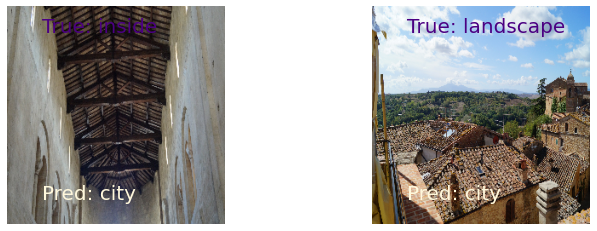

In [22]:
plot_misclassified(test_ds)

Ok, the right one was a bit misleading since buildings cover majority of ground area in that picture but the left image is a bit surprising because of close walls and a ceiling not visible in photos taken outside.